# 测量到中心线的距离
一个常见的问题是如何确定点到分割对象中心的距离。为此，我们可以对对象进行骨架化，生成距离图，并在给定点处读取距离图的强度，以确定它们到骨架/中心线的距离。

另请参阅：
* https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html
* https://examples.itk.org/src/filtering/distancemap/maurerdistancemapofbinary/documentation
* https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html

In [1]:
from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_simpleitk_image_processing as nsitk
import numpy as np
import stackview
import pyclesperanto_prototype as cle

## 起点：二值图像
我们从一个看起来像手臂的二值图像开始。

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
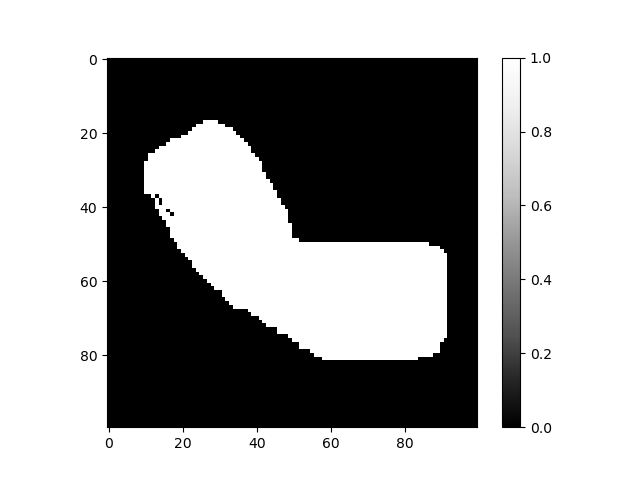
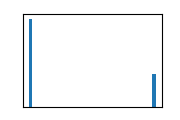

In [2]:
binary_arm = imread("../../data/binary_arm.tif")
stackview.insight(binary_arm)

此外，我们继续使用X/Y格式的坐标列表：

In [3]:
coordinates_xy = np.asarray([
                  [70, 80],
                  [70, 70],
                  [70, 60]]).T

接下来，我们生成一个标签图像，其中给定的坐标被标记。列表中的第一个坐标（索引=0）将被标记为1，第二个坐标标记为2，依此类推。背景像素为0。
我们使用这个标签图像进行可视化，在下面，我们还将使用这个图像进行测量。

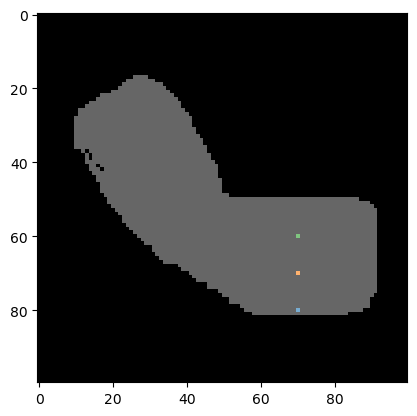

In [4]:
# draw the coordinates into an image; for visualization purposes
blank_image = cle.create((binary_arm.shape))
labeled_spots = coordinate_visualization = cle.pointlist_to_labelled_spots(coordinates_xy, blank_image)

# show the labeled pixels on top of the binary image
cle.imshow(binary_arm, continue_drawing=True, max_display_intensity=1)
cle.imshow(labeled_spots, labels=True, alpha=0.6)

## 预处理
在我们可以对图像进行骨架化之前，我们需要填充白色区域中的黑色孔洞。

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
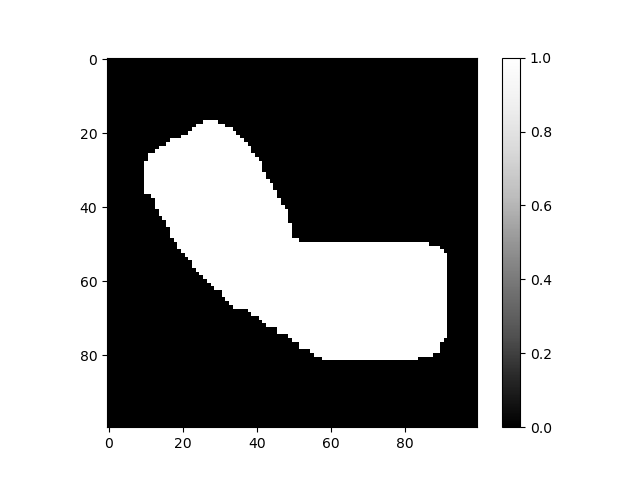
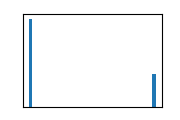

In [5]:
filled_holes = nsitk.binary_fill_holes(binary_arm)
filled_holes

## 骨架化
[二值图像的骨架](https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html)是白色区域中心的一条细线。

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
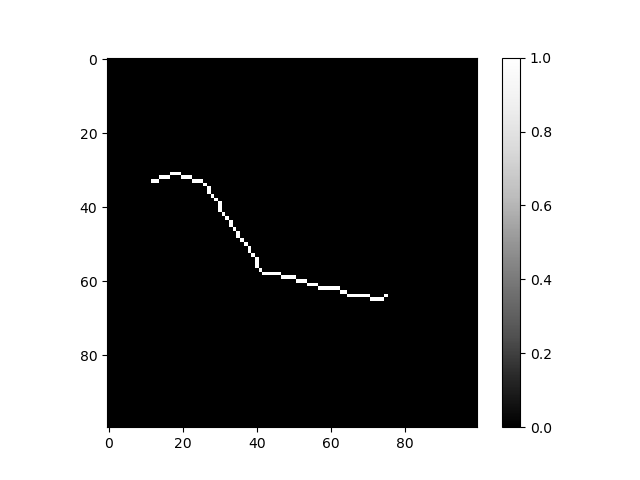
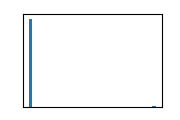

In [6]:
skeleton = nsbatwm.skeletonize(filled_holes)
skeleton

## 距离图
接下来，我们绘制一个有符号Maurer距离图。距离图是一种图像，其中像素的强度表示该像素到生成距离图的二值图像中最近的白色像素的距离。

StackViewNDArray([[-34.928497, -34.539833, -34.176014, ..., -67.6757  ,
                   -68.007355, -68.35203 ],
                  [-34.0147  , -33.61547 , -33.24154 , ..., -66.730804,
                   -67.06713 , -67.41662 ],
                  [-33.105892, -32.695564, -32.31099 , ..., -65.78754 ,
                   -66.12866 , -66.48308 ],
                  ...,
                  [-57.280014, -56.568542, -55.86591 , ..., -39.40812 ,
                   -40.      , -40.60788 ],
                  [-57.982758, -57.280014, -56.568542, ..., -40.22437 ,
                   -40.804413, -41.400482],
                  [-58.694122, -57.982758, -57.280014, ..., -41.04875 ,
                   -41.617306, -42.201897]], dtype=float32)
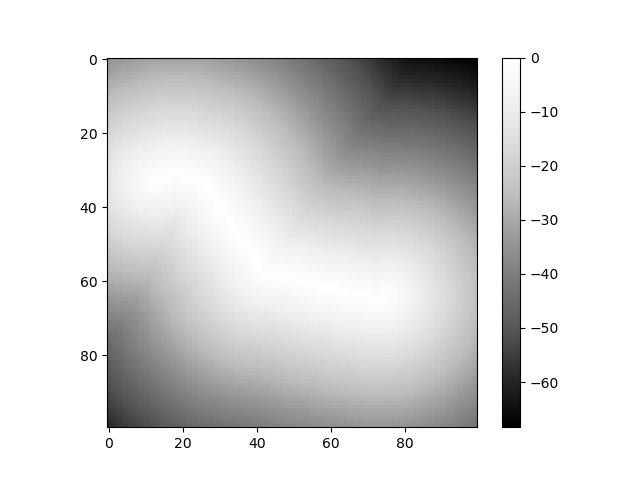
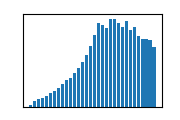

In [7]:
distance_map = nsitk.signed_maurer_distance_map(skeleton)
distance_map

使用[`stackview.picker`](https://github.com/haesleinhuepf/stackview#pick-intensities)，我们可以用鼠标悬停在图像上并读取强度。这只在类似Jupyter的环境中有效。

In [8]:
stackview.picker(distance_map, zoom_factor=3)

## 测量
现在我们可以在标记点的给定位置读取距离图中的强度。

In [9]:
values_at_positions = cle.read_intensities_from_positions(coordinates_xy, distance_map)
np.asarray(values_at_positions)

array([[-15.033297 ,  -5.0990195,  -4.       ]], dtype=float32)

## 练习
使用`binary_arm`图像的距离图来确定这三个点到手臂边缘的距离，而不是到中心线的距离。